In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
hurrloc = "../data/track_data/MARIA_2017"
df = pd.read_csv(hurrloc, skiprows=1)
hermlen = len(df[df.columns[0]])

hurrnum = np.ones(hermlen)
for i in range(hermlen):
    yearmoda = str(df[df.columns[0]][i])
    hours    = int(df[df.columns[1]][i]/100)
    dateform = datetime.datetime(int(yearmoda[:4]), int(yearmoda[4:6]), int(yearmoda[6:]), hours)
    hurrnum[i] = mdates.date2num(dateform)

latsN, lonsN = df.columns[4], df.columns[5]

hurrlats = [float(df[latsN][i][:-1]) for i in range(len(df[df.columns[0]]))]
hurrlons = [-float(df[lonsN][i][:-1]) for i in range(len(df[df.columns[0]]))]

In [3]:
#dataloc = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/all/ru28-20170915T1416.ncCFMA.nc3.nc"
dataloc = "http://gliders.ioos.us/thredds/dodsC/deployments/rutgers/striper-20170907T1430/striper-20170907T1430.nc3.nc?time[0:1:0][0:1:5832],latitude[0:1:0][0:1:5832],longitude[0:1:0][0:1:5832],depth[0:1:0][0:1:5832][0:1:151],pressure[0:1:0][0:1:5832][0:1:151],temperature[0:1:0][0:1:5832][0:1:151],salinity[0:1:0][0:1:5832][0:1:151],density[0:1:0][0:1:5832][0:1:151]"

In [4]:
df = xr.open_dataset(dataloc, decode_times=False)

In [5]:
df

<xarray.Dataset>
Dimensions:      (obs: 152, profile: 5833, trajectory: 1)
Coordinates:
    time         (trajectory, profile) float64 ...
    latitude     (trajectory, profile) float64 ...
    longitude    (trajectory, profile) float64 ...
    depth        (trajectory, profile, obs) float32 ...
Dimensions without coordinates: obs, profile, trajectory
Data variables:
    pressure     (trajectory, profile, obs) float32 ...
    temperature  (trajectory, profile, obs) float32 ...
    salinity     (trajectory, profile, obs) float32 ...
    density      (trajectory, profile, obs) float32 ...
Attributes:
    acknowledgment:                This deployment supported by United States...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    contributor_name:              Bill Boicourt, Chip Haldeman, David Aragon...
    contributor_role:              Primary Investigator, Glider Pilot, Glider...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 kerfoot@marine.rutgers.edu
    creator_name:                  John Kerfoot
    creator_url:                   http://rucool.marine.rutgers.edu
    date_created:                  2017-09-12T23:15:30Z
    date_issued:                   2017-09-12T23:15:30Z
    Easternmost_Easting:           -73.22953328670195
    featureType:                   TrajectoryProfile
    format_version:                /tmp/IOOS_Glider_NetCDF_v2.0-qartod.nc
    geospatial_lat_max:            39.46009896384581
    geospatial_lat_min:            37.55140806644617
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -73.22953328670195
    geospatial_lon_min:            -75.42070085025851
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       95.83
    geospatial_vertical_min:       1.11
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       2017-09-12T23:15:30Z /home/kerfoot/slocum/...
    id:                            striper-20170912T2350
    infoUrl:                       http://data.ioos.us/gliders/erddap/
    institution:                   University of Maryland
    ioos_dac_checksum:             559eebf5743a7462977877ab78c1aa42
    ioos_dac_completed:            False
    ioos_regional_association:     MARACOOS
    keywords:                      AUVS > Autonomous Underwater Vehicles, Ear...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       This data may be redistributed and used wi...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0, COARDS, CF...
    naming_authority:              edu.rutgers.marine
    Northernmost_Northing:         39.46009896384581
    platform_type:                 Slocum Glider
    project:                       MARACOOS
    publisher_email:               kerfoot@marine.rutgers.edu
    publisher_name:                John Kerfoot
    publisher_url:                 http://rucool.marine.rutgers.edu
    references:                    https://ioos.noaa.gov/wp-content/uploads/2...
    sea_name:                      Mid Atlantic Bight
    source:                        Observational data from a profiling glider
    sourceUrl:                     (local files)
    Southernmost_Northing:         37.55140806644617
    standard_name_vocabulary:      CF-v25
    subsetVariables:               trajectory,wmo_id,time_uv,lat_uv,lon_uv,u,...
    summary:                       Summer Glider Deployment. With UMass Dartm...
    time_coverage_end:             2017-09-27T08:28:49Z
    time_coverage_start:           2017-09-07T14:47:52Z
    title:                         striper-20170907T1430
    Westernmost_Easting:           -75.42070085025851
    DODS.strlen:                   7
    DODS.dimName:                  wmo_id_strlen
    trajectory.DO

In [6]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [7]:
from geopy.distance import geodesic

glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

b = np.amin(distance_metric)
print(b)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrnum[ktime]
eyepassage

139.31115920528026


17437.0

In [8]:
start = mdates.date2num(datetime.datetime(2017,9,22))
enddd = mdates.date2num(datetime.datetime(2017,9,27))

In [9]:
dP = np.gradient(df.depth[0,:,:].values, axis=(1))
dt = np.gradient(datenum, axis=(1)) / 96400
dPdt = dP/dt

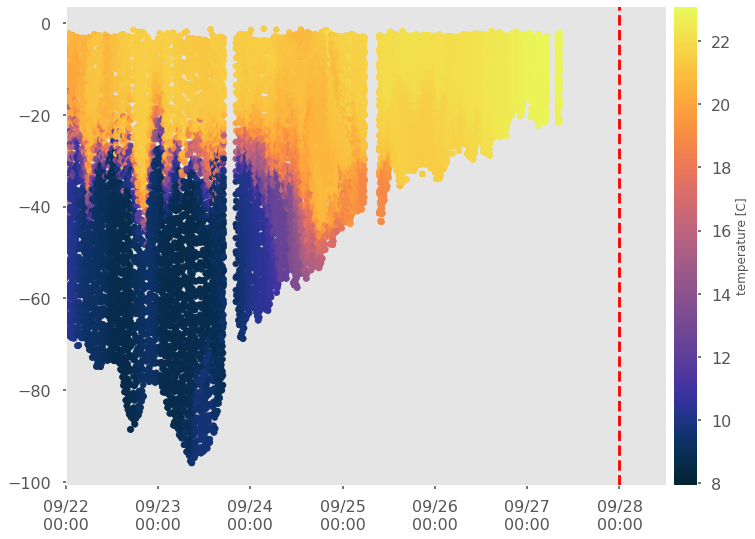

In [10]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.xlim([start, enddd+1.5])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [11]:
def discrete_to_grid(times_in,depth_in,variable,times_grid,depths_grid):
    from scipy.interpolate import interp1d
    N = len(times_in)
    time_array = times_grid[:,0]
    deptharray = depths_grid[0,:]
    var_out = np.ones_like(times_grid)
    # loop over index of input coordinates
    dT = 1/24/2.5
    for j, T in enumerate(time_array):
        # centre coordinates on estimation point
        #print(T, times_in.shape)
        lowC = times_in > T-dT
        hiC  = times_in < T+dT
        q = np.logical_and(lowC,hiC)
        dep = depth_in[q]
        var = variable[q]
        #print(np.shape(var))
        f = interp1d(dep,var,kind='linear')
        tmp = np.ones_like(deptharray)*np.nan
        q_less = np.where(deptharray<np.nanmax(dep))
        q_more = np.where(deptharray>np.nanmin(dep))
        q = np.intersect1d(q_more,q_less)
        dtmp = deptharray[q]
        tmp[q] = f(deptharray[q])
        var_out[j,:] = tmp    
    return var_out

In [12]:
times = datenum[0,:,0]
depth = np.arange(1,60,2)
DEPTH, TIMES = np.meshgrid(depth,times)

In [13]:
TEMPS = discrete_to_grid(datenum[0,:,:].reshape(-1), df.depth[0,:,:].values.reshape(-1), df.temperature[0,:,:].values.reshape(-1),TIMES, DEPTH)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


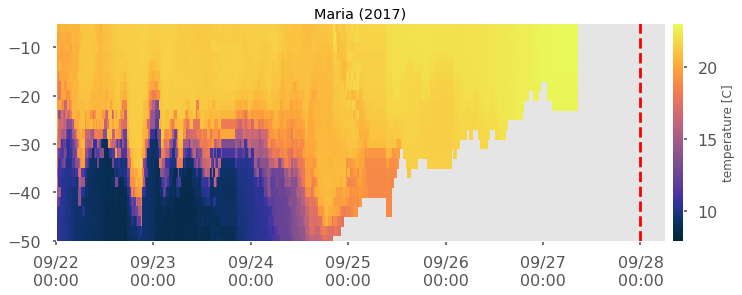

In [15]:
plt.figure(figsize=(13,4))
plt.pcolor(TIMES,-DEPTH,TEMPS, cmap='cmo.thermal') #, levels=np.linspace(8,24,17))
plt.colorbar(pad=0.01, label="temperature [C]")
plt.title("Maria (2017)")
plt.ylim([-50,-5])
plt.xlim([start, enddd+1.25])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.savefig("FIGS/temperatures_Maria2017.pdf", bbox_inches='tight')
plt.show()

In [16]:
st = mdates.date2num(datetime.datetime(2017,9,22))
en = mdates.date2num(datetime.datetime(2017,9,24))

a = times < en
b = times > st
q = np.logical_and(a,b)
temps_before = TEMPS[q,:]
temps_before = np.nanmean(temps_before, axis=(0))

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


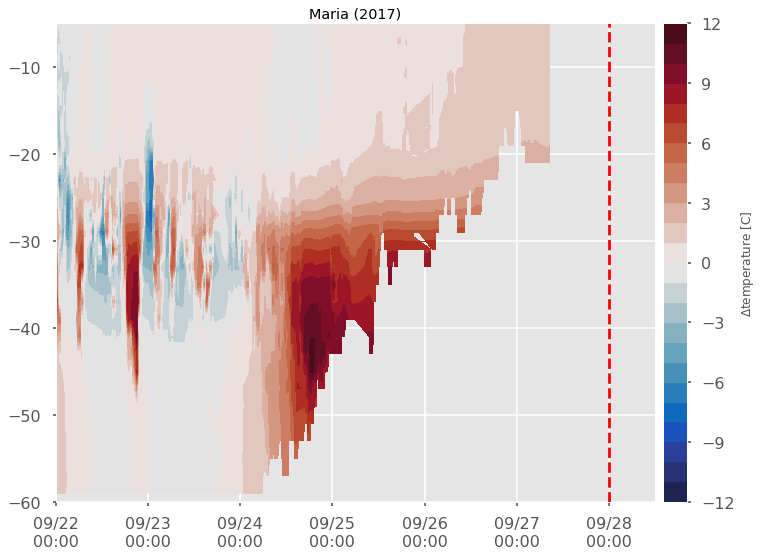

In [17]:
plt.contourf(TIMES,-DEPTH,TEMPS-temps_before[np.newaxis,:], cmap='cmo.balance', levels=np.linspace(-12,12,25))
plt.colorbar(pad=0.01, label="$\Delta$temperature [C]")
plt.ylim([-60,-5])
plt.xlim([start, enddd+1.5])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Maria (2017)')
plt.savefig("FIGS/dT_Maria2017.pdf", bbox_inches='tight')
plt.show()

In [18]:
winddata = "../data/ndbc_years/44065h2017.txt"
winddat2 = "../data/ndbc_years/44009h2017.txt"

In [19]:
ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(winddat2, skiprows=[1], delim_whitespace=True)

In [20]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

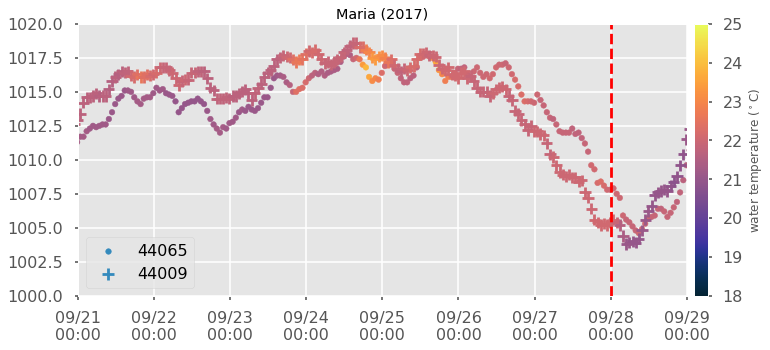

In [37]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], vmin=18, vmax=25, cmap=cmo.thermal, marker=".", label="44065")
plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=18, vmax=25, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='water temperature ($^\circ$C)')
plt.xlim([start-1, enddd+2])
plt.legend()
plt.ylim([1000,1020])
plt.title('Maria (2017)')
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)

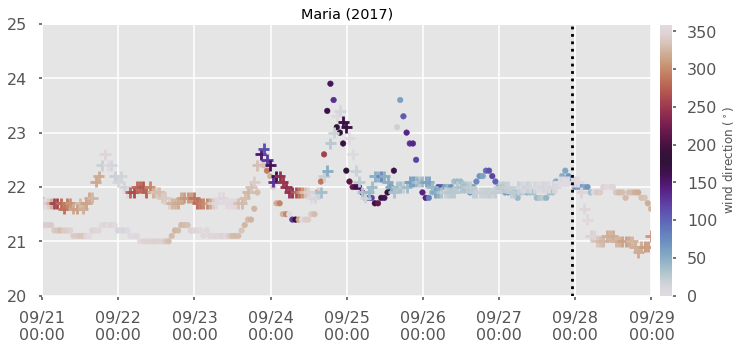

In [39]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker=".", label="44065", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.scatter(nd2_datenum,nd2['WTMP'], marker="+", label="44009", c=nd2['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.axvline(x = eyepassage-1/24, c='k', linestyle=":")
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([start-1, enddd+2])
plt.ylim([20,25])
plt.title('Maria (2017)')
plt.gca().xaxis.set_major_formatter(myFmt)

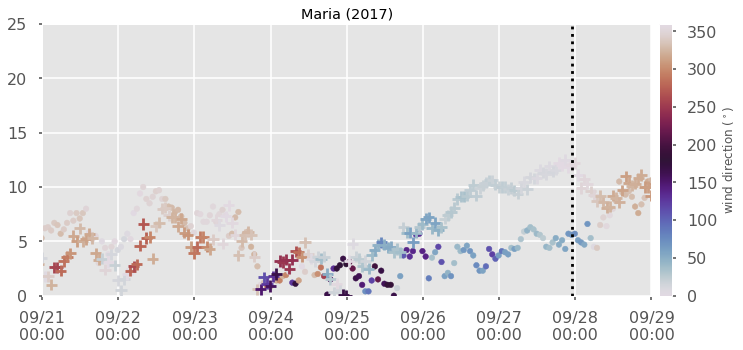

In [40]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WSPD'], marker=".", label="44065", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.scatter(nd2_datenum,nd2['WSPD'], marker="+", label="44009", c=nd2['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.axvline(x = eyepassage-1/24, c='k', linestyle=":")
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([start-1, enddd+2])
plt.ylim([0,25])
plt.title('Maria (2017)')
plt.gca().xaxis.set_major_formatter(myFmt)